## **RADI605: Modern Machine Learning**
## [In progress] <code> TODO: </code> 
<code> 1. Improve performance metrics </code> 
<code> 2. Exploratory Data Analysis </code>


### Assignment: Adaptive Boosting
**Romen Samuel Rodis Wabina** <br>
Student, PhD Data Science in Healthcare and Clinical Informatics <br>
Clinical Epidemiology and Biostatistics, Faculty of Medicine (Ramathibodi Hospital) <br>
Mahidol University

Note: In case of Python Markdown errors, you may access the assignment through this GitHub [Link](https://github.com/rrwabina/RADI605/blob/main/05%20Adaptive%20Boosting/scripts/assignment.ipynb)

### <code> Question 1-2. Please select one dataset from [UCI](https://archive.ics.uci.edu/ml/index.php). Describe the data characteristics by using appropriate statistical techniques. </code> 

In [26]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from numpy import mean
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

from statsmodels.stats.outliers_influence import variance_inflation_factor

import random
import warnings
warnings.filterwarnings('ignore')

We utilized the Cervical Cancer Behaviour Risk Dataset for this simulation. This dataset contains 19 attributes regarding cervical cancer with two (2) class labels, denoted as <code>ca_cervix</code>, with 1 and 0 as values - which means the respondent with and without cervical cancer, respectively. In addition,  the dependent variable <code>ca_cervix</code> is discrete and categorical in nature while its attributes are integers. 

In [12]:
data = pd.read_csv('../data/sobar-72.csv', sep = ',', header = 0)
print(f'The dataset contains {data.shape[0]} respondents with {data.shape[1]} attributes.')
data.head(10)

The dataset contains 72 respondents with 20 attributes.


,behavior_sexualRisk,behavior_eating,behavior_personalHygine,intention_aggregation,intention_commitment,attitude_consistency,attitude_spontaneity,norm_significantPerson,norm_fulfillment,perception_vulnerability,perception_severity,motivation_strength,motivation_willingness,socialSupport_emotionality,socialSupport_appreciation,socialSupport_instrumental,empowerment_knowledge,empowerment_abilities,empowerment_desires,ca_cervix
0,10,13,12,4,7,9,10,1,8,7,3,14,8,5,7,12,12,11,8,1
1,10,11,11,10,14,7,7,5,5,4,2,15,13,7,6,5,5,4,4,1
2,10,15,3,2,14,8,10,1,4,7,2,7,3,3,6,11,3,3,15,1
3,10,11,10,10,15,7,7,1,5,4,2,15,13,7,4,4,4,4,4,1
4,8,11,7,8,10,7,8,1,5,3,2,15,5,3,6,12,5,4,7,1
5,10,14,8,6,15,8,10,1,3,4,2,14,8,7,2,7,13,9,6,1
6,10,15,4,6,14,6,10,5,3,7,2,7,13,3,3,15,3,3,5,1
7,8,12,9,10,10,5,10,5,5,5,2,10,9,13,2,9,8,7,12,1
8,10,15,7,2,15,6,10,1,3,5,2,9,15,13,10,15,13,15,15,1
9,7,15,7,6,11,8,8,5,3,3,4,15,3,8,2,9,3,4,4,1


In [13]:
data.columns.values 

array(['behavior_sexualRisk', 'behavior_eating',
       'behavior_personalHygine', 'intention_aggregation',
       'intention_commitment', 'attitude_consistency',
       'attitude_spontaneity', 'norm_significantPerson',
       'norm_fulfillment', 'perception_vulnerability',
       'perception_severity', 'motivation_strength',
       'motivation_willingness', 'socialSupport_emotionality',
       'socialSupport_appreciation', 'socialSupport_instrumental',
       'empowerment_knowledge', 'empowerment_abilities',
       'empowerment_desires', 'ca_cervix'], dtype=object)

The given dataset contains values with integer data types and are not null.

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   behavior_sexualRisk         72 non-null     int64
 1   behavior_eating             72 non-null     int64
 2   behavior_personalHygine     72 non-null     int64
 3   intention_aggregation       72 non-null     int64
 4   intention_commitment        72 non-null     int64
 5   attitude_consistency        72 non-null     int64
 6   attitude_spontaneity        72 non-null     int64
 7   norm_significantPerson      72 non-null     int64
 8   norm_fulfillment            72 non-null     int64
 9   perception_vulnerability    72 non-null     int64
 10  perception_severity         72 non-null     int64
 11  motivation_strength         72 non-null     int64
 12  motivation_willingness      72 non-null     int64
 13  socialSupport_emotionality  72 non-null     int64
 14  socialSuppor

To find the correlation among the variables, we can make use of the correlation function <code>data.corr()</code>. This will give you a fair idea of the correlation strength between different variables. The figure below suggests the dataset's attributes is variedly correlated to other variables because there are attributes that are positively and negatively correlated to other variables. For instance, <code>empowerment_knowledge</code> is negatively correlated with <code>norm_fulfillment</code> with <code>$r = -0.001287$</code> while <code>perception_severity</code> is highly correlated with <code>norm_fulfillment</code> with $r = 0.853534$. This implies that variables with positive correlation exists when two variables operate in unison so that one variable rises or falls, the other does the same. A negative correlation is when two variable move oppositve one another so that when one variable rises, the other falls. These correlation results are important so that we can know how the change in one variable would impact the other parameter - especially when we feed the dataset to the machine learning model. 

<AxesSubplot:>

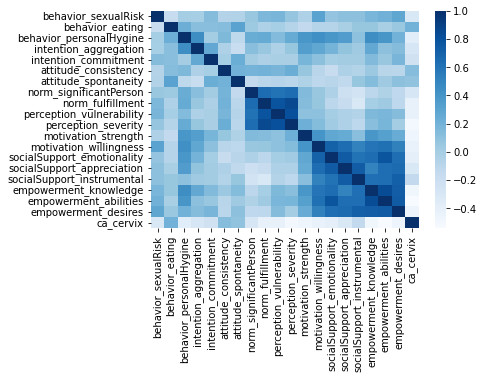

In [3]:
plt.figure(figsize=(6,4))
sns.heatmap(data.corr(),cmap = 'Blues', annot = False) 

Here, we make use of the Variance Inflation Factor to check the multicollinearity of data. To verify that multicollinearity does not exists; the <code>VIF</code> of every variable must not reach 10. If the <code>VIF</code> is equal to 1, there is no multicollinearity among factors, but if the <code>VIF</code> is greater than 1, the predictors may be highly correlated. A <code>VIF</code> between 5 and 10 indicates high correlation that may be problematic. If the <code>VIF</code> goes above 10, you can assume that the regression coefficients are poorly estimated due to multicollinearity. Statistically, and by theory, we should drop variables with high VIF. However,we care more about the predictions on how it affects the target variable due to the group of features rathen on each individual feature, then not removing multicollinearity may be a good option.

In [27]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
vif['Features'] = data.columns
vif

,VIF,Features
0,56.035416,behavior_sexualRisk
1,48.366256,behavior_eating
2,39.516902,behavior_personalHygine
3,17.198068,intention_aggregation
4,42.955054,intention_commitment
5,36.515882,attitude_consistency
6,49.479450,attitude_spontaneity
7,10.616087,norm_significantPerson
8,24.340401,norm_fulfillment
9,22.962378,perception_vulnerability


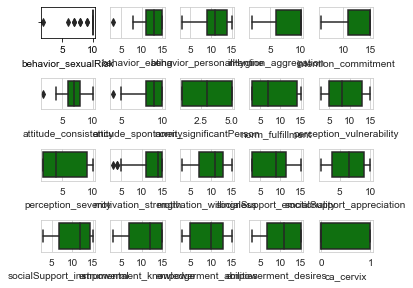

In [4]:
l = data.columns.values
number_of_columns= 5
number_of_rows = data.shape[0]
plt.figure(figsize=(number_of_columns, 1 * number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1, number_of_columns, i+1)
    sns.set_style('whitegrid')
    sns.boxplot(data[l[i]],color='green',orient='v')
    plt.tight_layout()

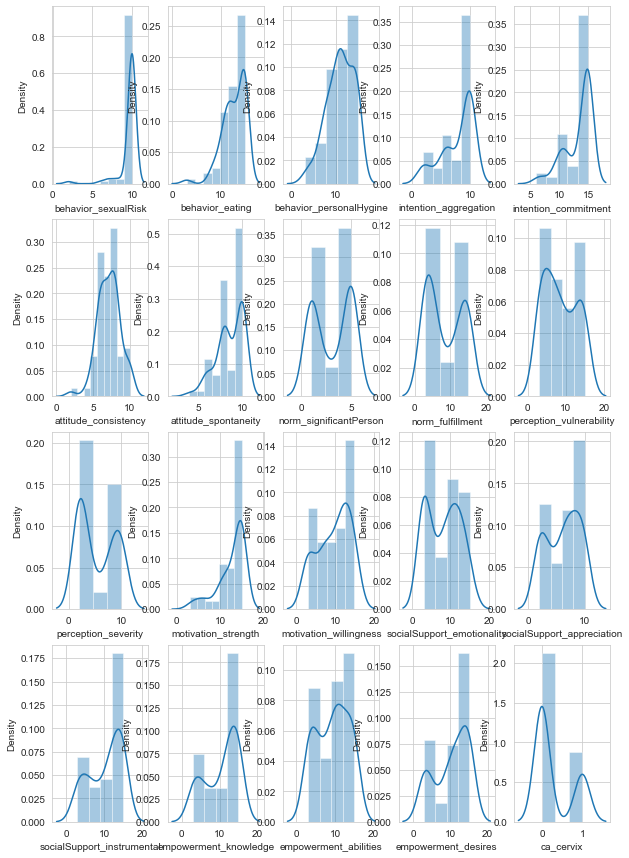

In [137]:
plt.figure(figsize=(10, 15))
for i in range(0,len(l)):
    plt.subplot(4, 5, i+1)
    sns.distplot(data[l[i]],kde=True) 

### Data Preprocessing

In [11]:
X = data.iloc[:, 0:19].to_numpy()
y = data.iloc[:, 19].to_numpy()
y[y == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

### <code> Question 3. Create an adaptive boosting classifier with decision tree and SVM by using a python sklearn package. </code>

In [142]:
def train_adaboost(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    class_names = ['Cervical Cancer', 'Healthy']
    
    confusion = confusion_matrix(y_test, y_pred)
    
    print("Adaptive Boosting score: ", np.round(accuracy_score(y_test, y_pred), 3))
    print('Confusion Matrix : \n', confusion)
    
    print(classification_report(y_test, y_pred, target_names = class_names))

## <code> Adaptive Boosting using Support Vector Machines </code>

In [143]:
def init_params():
    tuned_parameters = [{   'kernel': ['rbf'],
                            'gamma': [1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-7], 
                            'C': [0.001, 0.10, 0.1, 10, 20, 25, 50, 100, 1000]},

                        {   'kernel': ['sigmoid'], 
                            'gamma': [1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-7], 
                            'C': [0.001, 0.10, 0.1, 10, 20, 25, 50, 100, 1000]},

                        {   'kernel': ['linear'], 
                            'C': [0.001, 0.10, 0.1, 10, 20, 25, 50, 100, 1000]}]

    scoring = {'Precision': 'precision', 
               'Recall': 'recall', 
               'Accuracy': 'accuracy', 
               'AUC': 'roc_auc', 'F1': 'f1_micro'}

    return tuned_parameters, scoring

def get_svmtuning(X_train, y_train, cv = 10):
    tuned_parameters, scoring = init_params()
    random.seed(413)
    for name, score in zip(scoring.keys(), scoring.values()):
        clf = GridSearchCV(SVC(C = 1000), param_grid = tuned_parameters, cv = cv,
                            scoring = score, refit = 'Accuracy',
                            return_train_score = True)
        clf.fit(X_train, y_train)
        results = clf.cv_results_
        print(f'Best parameter set found on development set for {name}: \t {clf.best_params_}')
        return clf

get_svmtuning(X_train, y_train, cv = 10)
clf = SVC(kernel = 'rbf', C = 1210, gamma = 0.001)
adaboost_svm = AdaBoostClassifier(clf, algorithm = 'SAMME', n_estimators = 10, random_state = 0, learning_rate = 0.01)
train_adaboost(adaboost_svm)

Best parameter set found on development set for Precision: 	 {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Adaptive Boosting score:  1.0
Confusion Matrix : 
 [[14  0]
 [ 0  8]]
                 precision    recall  f1-score   support

Cervical Cancer       1.00      1.00      1.00        14
        Healthy       1.00      1.00      1.00         8

       accuracy                           1.00        22
      macro avg       1.00      1.00      1.00        22
   weighted avg       1.00      1.00      1.00        22



## <code> Adaptive Boosting using Decision Tree </code>

In [141]:
param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha'   : np.arange(0.001, 0.1, 0.01),
              'max_depth'   : np.arange(1, 15),
              'criterion'   : ['gini', 'entropy']}

tree_class = DecisionTreeClassifier(max_depth = 5, random_state = 1024)
grid_search = GridSearchCV(estimator = tree_class, param_grid = param_grid, cv = 5, verbose = True)
grid_search.fit(X_train, y_train)

adaboost_dct = AdaBoostClassifier(grid_search.best_estimator_, n_estimators = 3000, random_state = 0, learning_rate = 0.001)
train_adaboost(adaboost_dct)

Fitting 5 folds for each of 840 candidates, totalling 4200 fits
Adaptive Boosting score:  0.864
Confusion Matrix : 
 [[14  0]
 [ 3  5]]
                 precision    recall  f1-score   support

Cervical Cancer       0.82      1.00      0.90        14
        Healthy       1.00      0.62      0.77         8

       accuracy                           0.86        22
      macro avg       0.91      0.81      0.84        22
   weighted avg       0.89      0.86      0.85        22



SVM and Decision Trees were used as weak classifiers, and as seen on the respective classification matrix, SVM as a weak classifier has better performance than Decision Trees